In [1]:
using Plots
using SpecialFunctions
using LaTeXStrings
using Plots.PlotMeasures

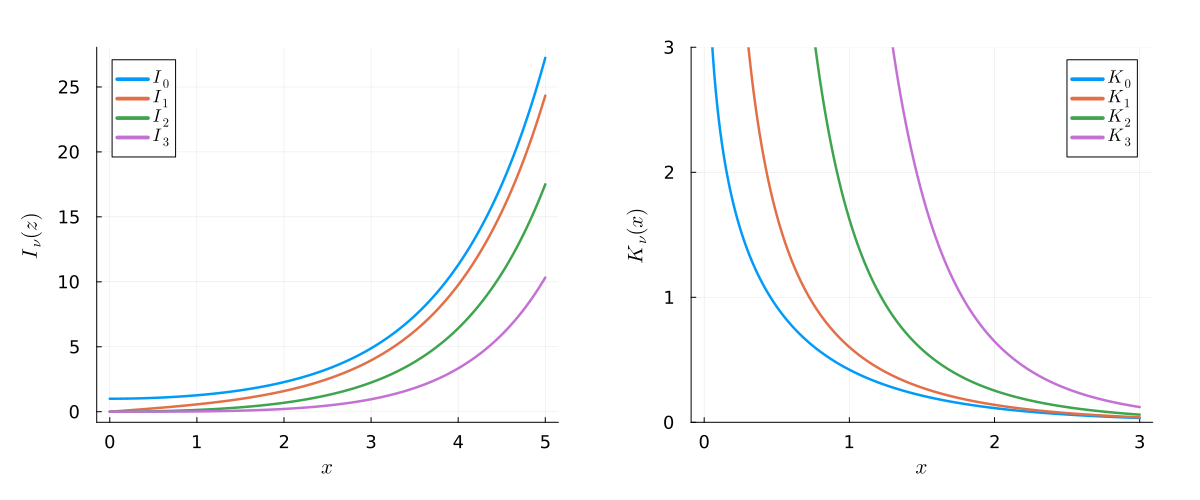

In [36]:
# plot scaled modified bessel function I(z) for order 0, 1, 2, 3
z = 0:0.01:5
lw = 2.5

p = plot(z, besseli.(0, z), 
    label=L"I_0", 
    linewidth=lw,
    size=(600, 600),
    legendfontsize=12, 
    tickfontsize=12, 
    guidefontsize=14)
plot!(p, z, besseli.(1, z), label=L"I_1", linewidth=lw)
plot!(p, z, besseli.(2, z), label=L"I_2", linewidth=lw)
plot!(p, z, besseli.(3, z), label=L"I_3", linewidth=lw)

xlabel!(L"x")
ylabel!(L"I_{\nu}(z)")
z = 0:0.01:3
# Create a second plot for K_ν(z)
p2 = plot(z, besselk.(0, z), 
    label=L"K_0", 
    linewidth=lw,
    size=(600, 600),
    legendfontsize=12, 
    tickfontsize=12, 
    guidefontsize=14)
plot!(p2, z, besselk.(1, z), label=L"K_1", linewidth=lw)
plot!(p2, z, besselk.(2, z), label=L"K_2", linewidth=lw)
plot!(p2, z, besselk.(3, z), label=L"K_3", linewidth=lw)
ylims!(p2, 0, 3)

xlabel!(p2, L"x")
ylabel!(p2, L"K_{\nu}(x)")

# Combine both plots into a single figure with subplots
combined_plot = plot(p, p2, layout=(1, 2), size=(1200, 500), margin=10mm)

# save figure as a svg file
savefig(combined_plot, "bessel_plots.pdf")

combined_plot

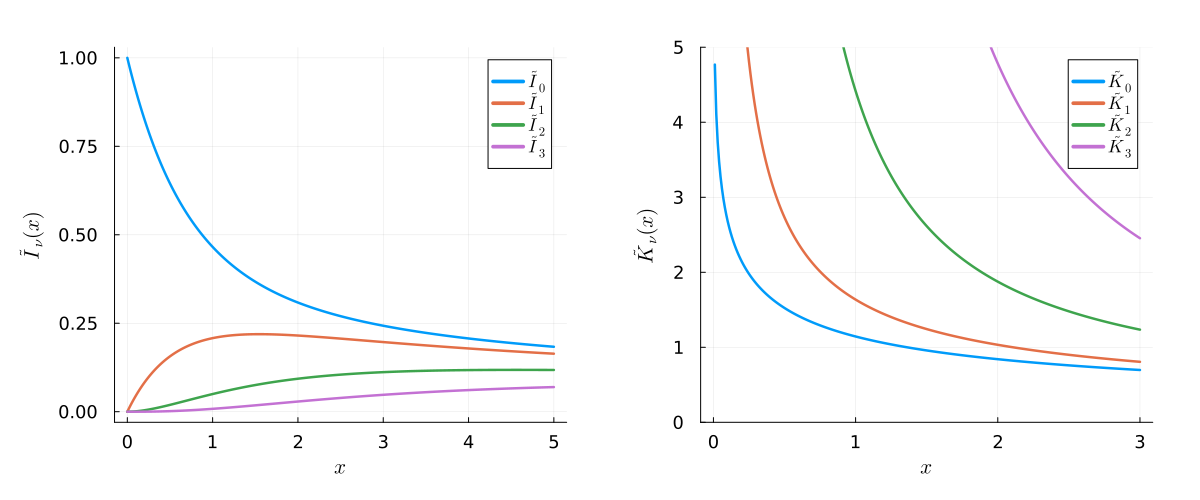

In [33]:
# Plot scaled modified bessel functions I_ν(z) * exp(-z) and K_ν(z) * exp(z)
z = 0:0.01:5
lw = 2.5

# First plot for scaled I_ν(z) * exp(-z)
p_scaled_i = plot(z, besselix.(0, z), 
    label=L"\tilde{I}_0", 
    linewidth=lw,
    size=(600, 600),
    legendfontsize=12, 
    tickfontsize=12, 
    guidefontsize=14)
plot!(p_scaled_i, z, besselix.(1, z), label=L"\tilde{I}_1", linewidth=lw)
plot!(p_scaled_i, z, besselix.(2, z), label=L"\tilde{I}_2", linewidth=lw)
plot!(p_scaled_i, z, besselix.(3, z), label=L"\tilde{I}_3", linewidth=lw)

xlabel!(p_scaled_i, L"x")
ylabel!(p_scaled_i, L"\tilde{I}_{\nu}(x)")

# Second plot for scaled K_ν(z) * exp(z)
z = 0:0.01:3
p_scaled_k = plot(z, besselkx.(0, z), 
    label=L"\tilde{K}_0", 
    linewidth=lw,
    size=(600, 600),
    legendfontsize=12, 
    tickfontsize=12, 
    guidefontsize=14)
plot!(p_scaled_k, z, besselkx.(1, z), label=L"\tilde{K}_1", linewidth=lw)
plot!(p_scaled_k, z, besselkx.(2, z), label=L"\tilde{K}_2", linewidth=lw)
plot!(p_scaled_k, z, besselkx.(3, z), label=L"\tilde{K}_3", linewidth=lw)
ylims!(p_scaled_k, 0, 5)

xlabel!(p_scaled_k, L"x")
ylabel!(p_scaled_k, L"\tilde{K}_{\nu}(x)")

# Combine both scaled plots into a single figure with subplots
scaled_combined_plot = plot(p_scaled_i, p_scaled_k, layout=(1, 2), size=(1200, 500), margin=10mm)

# Save figure as a pdf file
savefig(scaled_combined_plot, "scaled_bessel_plots.pdf")

scaled_combined_plot


### Using SpecialFunctions.jl

In [108]:
function β_scaled(k, S, b)
    
    kb = k*b
    kS = k.*S

    # preallocate L₁ and L₂
    L₁ = zeros(length(S))
    L₂ = zeros(length(S))

    # compute L₁ and L₂
    L₁ .= kS .- kb .+ log.(besselkx.(1, kb)) .+ log.(besselix.(1, kS))
    L₂ .= kb .- kS .+ log.(besselix.(1, kb)) .+ log.(besselkx.(1, kS))

    # preallocate β
    β = zeros(length(S))

    # compute max of L₁ and L₂ (ensure stabilization is applied for each element in domain)
    M = max.(L₁, L₂)

    # compute β
    β .= exp.(M) .* (exp.(L₁ .- M) .- exp.(L₂ .- M))

    return β
end

β_scaled (generic function with 1 method)

In [109]:
function β_naive(k, S, b)

    β = besselk.(1, (k * b)) .* besseli.(1, (k .* S)) .- besseli.(1, (k * b)) .* besselk.(1, (k .* S))

    return β
end

β_naive (generic function with 1 method)

In [219]:
function β_slightly_scaled(k, S, b)
    kb = k*b
    kS = k.*S

    A = (1/2) .* (kS .- kb)

    # preallocate β
    β = zeros(length(S))

    # compute β
    β .= exp.(2 .* A) .* (besselkx.(1, kb) .* besselix.(1, kS)) .- exp.(-2 .* A) .* (besselix.(1, kb) .* besselkx.(1, kS)) 

    return β
end

β_slightly_scaled (generic function with 1 method)

### Using Bessels.jl

In [217]:
using Bessels

### **Scaled vs. Naive**

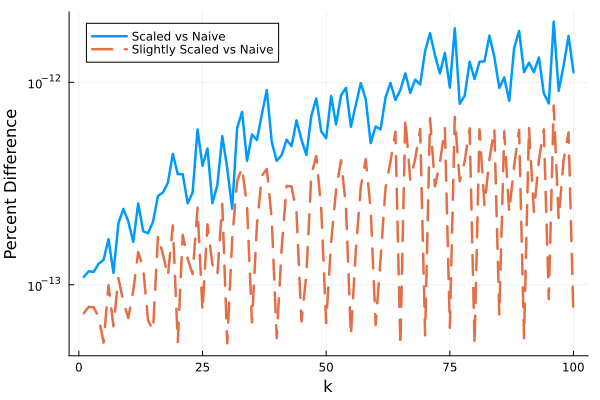

In [225]:
# test scaled and naive approches 

z = -π:0.0001:π
S = 1 .+ 0.1 .* cos.(z) .+ 0.001 .* cos.(z) .+ 0.0001 .* cos.(z) .+ 0.00001 .* cos.(z)
b = 0.1

# Define a range of k values
k_values = 1:100

# Compute the difference for each k value
differences = zeros(length(k_values))
differences_slightly_scaled = zeros(length(k_values))
for (i, k) in enumerate(k_values)
    # Calculate the scaled and naive approaches
    scaled = β_scaled(k, S, b)
    naive = β_naive(k, S, b)
    slightly_scaled = β_slightly_scaled(k, S, b)

    # Percent difference between naive and scaled
    percent_diff = abs.((scaled .- naive) ./ ((scaled .+ naive) ./ 2)) .* 100

    # Percent difference between naive and slightly scaled
    percent_diff_slightly_scaled = abs.((naive .- slightly_scaled) ./ ((naive .+ slightly_scaled) ./ 2)) .* 100

    # Store the maximum percent difference
    differences[i] = maximum(percent_diff)
    differences_slightly_scaled[i] = maximum(percent_diff_slightly_scaled)
end

# Plot the differences vs k

p = plot(yscale=:log10, xlabel="k", ylabel="Percent Difference")
plot!(p, k_values, differences, 
    label="Scaled vs Naive",
    linewidth=2.5)

plot!(k_values, differences_slightly_scaled, 
    label="Slightly Scaled vs Naive",
    linewidth=2.5,
    linestyle=:dash)

# println(mean(differences))

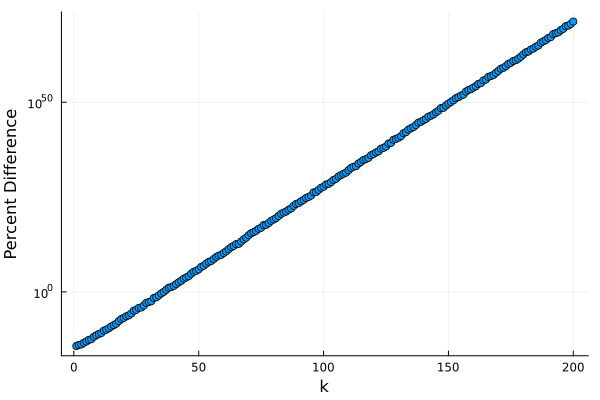

In [145]:
# test scaled and naive approches 

z = -π:0.0001:π
S = 1 .+ 0.1 .* cos.(z) .+ 0.001 .* cos.(z) .+ 0.0001 .* cos.(z) .+ 0.00001 .* cos.(z)
b = 0.1

# Define a range of k values
k_values = 1:200

# Compute the difference for each k value
differences = zeros(length(k_values))
for (i, k) in enumerate(k_values)
    # Calculate the scaled and naive approaches
    scaled = β_scaled(k, S, b)
    naive = β_naive(k, S, b)
    # Calculate the absolute difference between the two approaches
    abs_diff = abs.(scaled .- naive)
    # Store the maximum absolute difference
    differences[i] = maximum(abs_diff)
end

# Plot the differences vs k
plot(k_values, differences, 
    xlabel="k", 
    ylabel="Percent Difference",
    marker=:circle,
    legend=false, 
    yscale=:log10)

# println(mean(differences))

In [123]:
# Test when each method throws an error
k_values = 1:1:2000
scaled_error_k = nothing
naive_error_k = nothing

for k in k_values
    # Test scaled approach if no error found yet
    if isnothing(scaled_error_k)
        try
            β_scaled(k, S, b)
        catch e
            scaled_error_k = k
            println("Scaled method failed at k = $k with error: $(typeof(e))")
        end
    end
    
    # Test naive approach if no error found yet
    if isnothing(naive_error_k)
        try
            β_naive(k, S, b)
        catch e
            naive_error_k = k
            println("Naive method failed at k = $k with error: $(typeof(e))")
        end
    end
    
    # Break the loop if both methods have failed
    if !isnothing(scaled_error_k) && !isnothing(naive_error_k)
        break
    end
end

println("\nSummary:")
println("Scaled method failed at k = ", isnothing(scaled_error_k) ? "No failure detected" : scaled_error_k)
println("Naive method failed at k = ", isnothing(naive_error_k) ? "No failure detected" : naive_error_k)

Naive method failed at k = 637 with error: SpecialFunctions.AmosException

Summary:
Scaled method failed at k = No failure detected
Naive method failed at k = 637


In [134]:
β_scaled(860, S, b)

62832-element Vector{Float64}:
 4.669994097432032e295
 4.669996126507522e295
 4.670002213739812e295
 4.670012359145834e295
 4.670026562749913e295
 4.6700448245906685e295
 4.670067144714118e295
 4.67009352318004e295
 4.670123960055081e295
 4.670158455418588e295
 ⋮
 4.6701531327269325e295
 4.670119233675478e295
 4.670089393099639e295
 4.670063610922681e295
 4.670041887078984e295
 4.670024221510854e295
 4.6700106141727655e295
 4.670001065028185e295
 4.669995574053811e295

In [139]:
β_naive(636, S, b)

62832-element Vector{Float64}:
 1.2115830529784972e218
 1.2115834421982157e218
 1.2115846098585342e218
 1.2115865559615657e218
 1.211589280511061e218
 1.2115927835122722e218
 1.211597064971676e218
 1.2116021248978e218
 1.2116079633002595e218
 1.2116145801900335e218
 ⋮
 1.2116135591939085e218
 1.211607056686639e218
 1.2116013326650732e218
 1.2115963871180416e218
 1.2115922200366984e218
 1.2115888314124617e218
 1.2115862212389376e218
 1.2115843895112322e218
 1.211583336225815e218

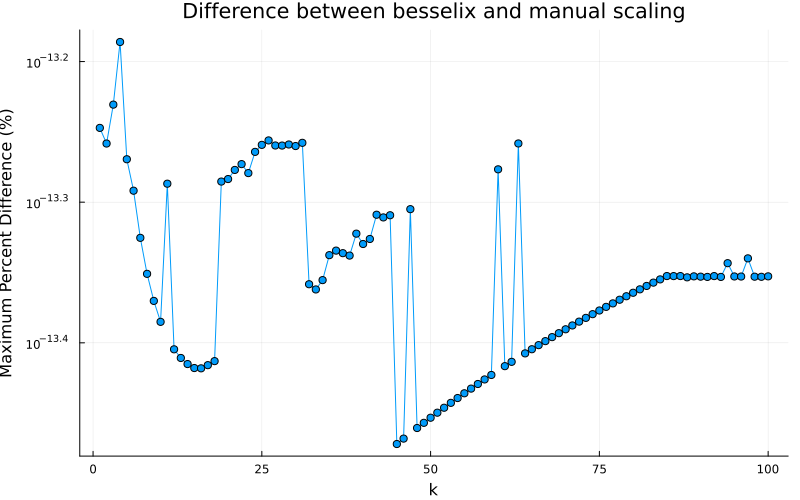

In [200]:
# Compare besselix vs manual scaling with besseli
k_values = 1:100  # Range of k values to test

# Initialize array to store maximum percent differences
max_differences = zeros(length(k_values))

for (i, k) in enumerate(k_values)
    kb = k .* S .* b
    
    # Method 1: Using besselix (scaled Bessel function)
    scaled_result = besselix.(1, kb)
    
    # Method 2: Manual scaling with besseli and exp
    manual_result = besseli.(1, kb) .* exp.(-kb)
    
    # Calculate the percent difference
    percent_diff = abs.((scaled_result .- manual_result) ./ manual_result) .* 100
    
    # Store the maximum percent difference for this k value
    max_differences[i] = maximum(percent_diff)
end

# Plot the maximum percent difference vs k
plot(k_values, max_differences, 
    xlabel="k", 
    ylabel="Maximum Percent Difference (%)",
    title="Difference between besselix and manual scaling",
    marker=:circle,
    legend=false, 
    yscale=:log10,
    size=(800, 500))



### **Quadruple Precision**

In [193]:
# show the methods of SpecialFunctions.besselk
methods(SpecialFunctions.besselk)

# 19 methods for generic function "besselk" from SpecialFunctions:
  [1] besselk(nu::Float64, z::ComplexF64)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:432
  [2] besselk(nu::Float16, x::ComplexF16)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:646
  [3] besselk(nu::Float32, x::ComplexF32)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:647
  [4] besselk(nu::ArbReal{P}, x::ArbReal{P}) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:6
  [5] besselk(nu::ArbReal{P}, x::ArbReal{P}, prec::Int64) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:6
  [6] besselk(nu::ArbFloat{P}, x::ArbFloat{P}) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:30
  [7] besselk(nu::S, x::ArbFloat{P}) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:35
  [8] besselk(nu::Real, x::AbstractFloat)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:567
  [9] besselk(nu::S, x::ArbReal{P}) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:40
 [10] besselk(nu::Real, x::Real)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:641
 [11] besselk(k::T, z::Complex{T}) where T<:AbstractFloat
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:648
 [12] besselk(nu::Real, z::Complex)
     @ ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:642
 [13] besselk(nu::ArbComplex{P}, x::ArbComplex{P}) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:18
 [14] besselk(nu::ArbComplex{P}, x::ArbComplex{P}, prec::Int64) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:18
 [15] besselk(nu::ArbFloat{P}, x::ArbFloat{P}, prec::Int64) where P
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:30
 [16] besselk(nu::S, x::ArbFloat{P}, prec::Int64) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:35
 [17] besselk(nu::S, x::ArbReal{P}, prec::Int64) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:40
 [18] besselk(nu::S, x::ArbComplex{P}) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:60
 [19] besselk(nu::S, x::ArbComplex{P}, prec::Int64) where {P, S<:Union{Float32, Float64, Int32, Int64}}
     @ ArbNumerics ~/.julia/packages/ArbNumerics/XPUKi/src/float/bessel.jl:60

In [199]:
using ArbNumerics
setprecision(ArbFloat, 113)
nu = ArbReal(1.5)
x = ArbReal(2.0)
result = SpecialFunctions.besselk(nu, x) 

0.179906657952092171052054752455190274329

In [147]:
using Quadmath

z = Float128(-π):Float128(0.0001):Float128(π)
S = Float128(1.0) .+ Float128(0.1) .* cos.(z) .+ Float128(0.001) .* cos.(z) .+ Float128(0.0001) .* cos.(z) .+ Float128(0.00001) .* cos.(z)
b = Float128(0.1)

# Define a range of k values
k_values = Float128(1):Float128(1):Float128(1000)

# Compute the difference for each k value
differences = zeros(Float128, length(k_values))
for (i, k) in enumerate(k_values)
    # Calculate the scaled and naive approaches
    scaled = β_scaled(k, S, b)
    naive = β_naive(k, S, b)
    # Calculate the percent difference between the two approaches
    percent_diff = abs.((scaled .- naive) ./ naive) .* Float128(100)
    # Store the maximum percent difference
    differences[i] = maximum(percent_diff)
end

# Plot the differences vs k
plot(k_values, differences, 
    xlabel="k", 
    ylabel="Percent Difference",
    marker=:circle,
    legend=false, 
    yscale=:log10)

MethodError: MethodError: no method matching besselkx(::Float128, ::Complex{Float128})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  besselkx(::T, ::Complex{T}) where T<:AbstractFloat
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:648
  besselkx(::Real, ::Complex)
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:642
  besselkx(::Real, !Matched::AbstractFloat)
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:590
  ...


In [150]:
using ArbNumerics

# Choose the numeric type to use
T = ArbFloat

# Set precision for ArbFloat
precision = 128
setworkingprecision(T, precision)

z = T(-π):T(0.0001):T(π)
S = T(1.0) .+ T(0.1) .* cos.(z) .+ T(0.001) .* cos.(z) .+ T(0.0001) .* cos.(z) .+ T(0.00001) .* cos.(z)
b = T(0.1)

# Define a range of k values
k_values = T(1):T(1):T(1000)

# Compute the difference for each k value
differences = zeros(T, length(k_values))
for (i, k) in enumerate(k_values)
    # Calculate the scaled and naive approaches
    scaled = β_scaled(k, S, b)
    naive = β_naive(k, S, b)
    # Calculate the percent difference between the two approaches
    percent_diff = abs.((scaled .- naive) ./ naive) .* T(100)
    # Store the maximum percent difference
    differences[i] = maximum(percent_diff)
end

# Plot the differences vs k
plot(k_values, differences, 
    xlabel="k", 
    ylabel="Percent Difference",
    marker=:circle,
    legend=false, 
    yscale=:log10)

MethodError: MethodError: no method matching besselkx(::Float64, ::ArbComplex{128})
The function `besselkx` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  besselkx(::Float64, !Matched::ComplexF64)
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:434
  besselkx(::T, !Matched::Complex{T}) where T<:AbstractFloat
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:648
  besselkx(::Real, !Matched::Complex)
   @ SpecialFunctions ~/.julia/packages/SpecialFunctions/Zijv9/src/bessel.jl:642
  ...
